In [38]:
#%% env: new-ml

from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm   
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import numpy as np
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#%%
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

In [39]:

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
    
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
      in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts 

In [84]:
clinical_lung = pd.read_csv('/mnt/storageG1/lwang/Projects/TBpt/Analysis/clinical_lung_na11182024.csv')
clinical_lung.drop(columns=['condition_id'], inplace=True)

country_mapping = {
    'China': 1,        # High medical capacity, large infrastructure, advanced technology
    'India': 2,        # Large infrastructure, but strained capacity due to population
    'South Africa': 3, # Developed healthcare, but regional disparities
    'Romania': 4,      # Developing EU healthcare standards
    'Ukraine': 5,      # Moderate capacity but strained due to recent conflicts
    'Belarus': 6,      # Moderate capacity, state-funded healthcare
    'Kazakhstan': 7,   # Developing healthcare system
    'Azerbaijan': 8,   # Developing healthcare system
    'Georgia': 9,      # Smaller healthcare capacity, improving
    'Moldova': 10,     # Limited resources, developing healthcare
    'Kyrgyzstan': 11,  # Limited resources, developing healthcare
    'Nigeria': 12,     # Limited healthcare capacity, large population challenges
    'Senegal': 13      # Developing healthcare system with limited resources
}

# Apply the mapping to the 'country' column
clinical_lung['country'] = clinical_lung['country'].replace(country_mapping).fillna(0)
clinical_lung_cleaned = clinical_lung.drop_duplicates()
clinical_lung_features = clinical_lung.drop(columns=['outcome', 'period_span.1'])
clinical_lung_target = clinical_lung[['outcome']]

## training/testing functions

In [112]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_xgboost_classifier(features, target, test_size=0.2, random_state=42):
    """
    Trains and evaluates an XGBoost classifier on the provided dataset.

    Parameters:
    - features (pd.DataFrame): The feature set.
    - target (pd.Series): The target variable.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - model (XGBClassifier): The trained XGBoost model.
    - metrics (dict): A dictionary containing accuracy, sensitivity, and specificity.
    """

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, random_state=random_state, stratify=target, shuffle=True
    )

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled arrays back to DataFrames to retain feature names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features.columns)

    # Initialize and train the XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    model.fit(X_train_scaled_df, y_train)

    # Predict on training and testing data
    y_train_pred = model.predict(X_train_scaled_df)
    y_test_pred = model.predict(X_test_scaled_df)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate sensitivity (recall) and specificity
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    specificity = recall_score(y_test, y_test_pred, pos_label=0)

    # Compile metrics into a dictionary
    metrics = {
        # 'Training Accuracy': train_accuracy,
        'Testing Accuracy': test_accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }

    # Print metrics
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(15, 25))
    plot_importance(model, max_num_features=20, importance_type='weight', xlabel='Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()

    return model, metrics

# Example usage:
# Assuming 'clinical_lung_features' is your DataFrame of features
# and 'clinical_lung_target' is your target variable
# model, metrics = evaluate_xgboost_classifier(clinical_lung_features, clinical_lung_target)
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_xgboost_classifier_split(X_train, X_test, y_train, y_test, reg_alpha=0.1, reg_lambda=0.1, random_state=42):
    """
    Trains and evaluates an XGBoost classifier on the provided training and testing datasets.

    Parameters:
    - X_train (pd.DataFrame): Training feature set.
    - X_test (pd.DataFrame): Testing feature set.
    - y_train (pd.Series or np.array): Training target variable.
    - y_test (pd.Series or np.array): Testing target variable.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - model (XGBClassifier): The trained XGBoost model.
    - metrics (dict): A dictionary containing accuracy, sensitivity, and specificity.
    """

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled arrays back to DataFrames to retain feature names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Initialize and train the XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state, reg_alpha=reg_alpha, reg_lambda=reg_lambda)
    model.fit(X_train_scaled_df, y_train)

    # Predict on training and testing data
    y_train_pred = model.predict(X_train_scaled_df)
    y_test_pred = model.predict(X_test_scaled_df)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate sensitivity (recall) and specificity
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    specificity = recall_score(y_test, y_test_pred, pos_label=0)

    # Compile metrics into a dictionary
    metrics = {
        # 'Training Accuracy': train_accuracy,
        'Testing Accuracy': test_accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }

    # Print metrics
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(15, 25))
    plot_importance(model, max_num_features=20, importance_type='weight', xlabel='Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()

    return model, metrics


Training Accuracy: 0.9951
Testing Accuracy: 0.9363
Sensitivity (Recall): 0.9768
Specificity: 0.7688


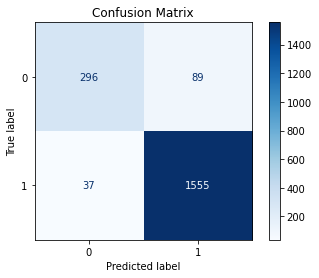

<Figure size 1080x1800 with 0 Axes>

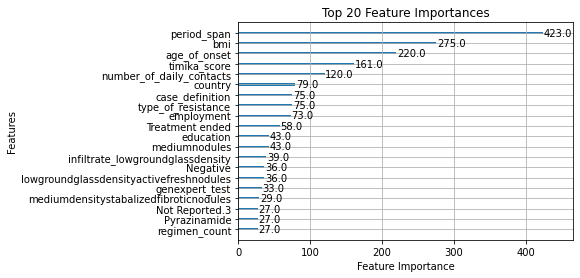

In [49]:
model, metrics = evaluate_xgboost_classifier(clinical_lung_features, clinical_lung_target)


## inputation with knn

Training Accuracy: 0.9968
Testing Accuracy: 0.9353
Sensitivity (Recall): 0.9793
Specificity: 0.7532


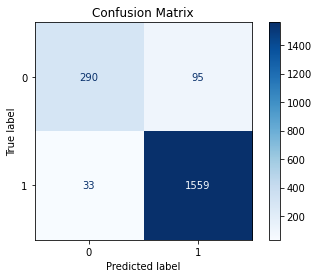

<Figure size 1080x1800 with 0 Axes>

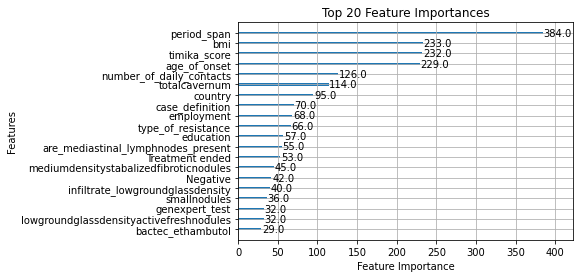

In [50]:
import pandas as pd
from sklearn.impute import KNNImputer

# Assuming 'clinical_lung_features' is your DataFrame with missing values

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

model, metrics = evaluate_xgboost_classifier(clinical_lung_features, clinical_lung_target)


## dropping period span columns

In [ ]:
clinical_lung_features['period_span']

Training Accuracy: 0.9877
Testing Accuracy: 0.8912
Sensitivity (Recall): 0.9604
Specificity: 0.6052


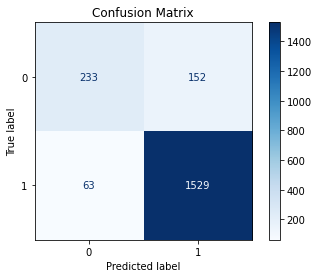

<Figure size 1080x1800 with 0 Axes>

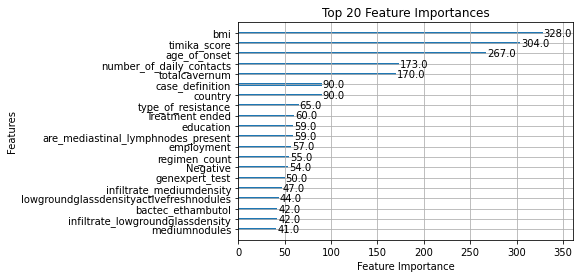

In [59]:
import pandas as pd
from sklearn.impute import KNNImputer

# Assuming 'clinical_lung_features' is your DataFrame with missing values

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Fit the imputer on the data and transform it
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

clinical_lung_features_imputed_df = clinical_lung_features_imputed_df.drop(columns=['period_span.1'])
# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

model, metrics = evaluate_xgboost_classifier(clinical_lung_features, clinical_lung_target)


removing period span drops specificity from 73 to 60, acc drop from 98 to 89

## adding pca 
hoping to reduce imbalance and improve specificity

Testing Accuracy: 0.8766
Sensitivity (Recall): 0.9655
Specificity: 0.5091


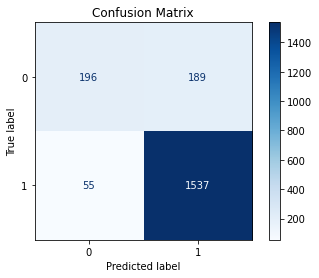

<Figure size 1080x1800 with 0 Axes>

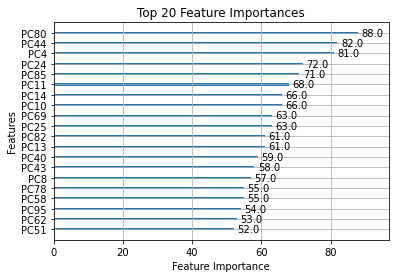

In [64]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'clinical_lung_features' is your DataFrame with missing values

# Step 1: Impute Missing Values Using KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Step 2: Remove the 'period_span.1' Variable
# clinical_lung_features_imputed_df = clinical_lung_features_imputed_df.drop(columns=['period_span.1'])

# Step 3: Standardize the Features
scaler = StandardScaler()
clinical_lung_features_scaled = scaler.fit_transform(clinical_lung_features_imputed_df)

# Step 4: Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
clinical_lung_features_pca = pca.fit_transform(clinical_lung_features_scaled)

# Convert the PCA result back to a DataFrame
pca_columns = [f'PC{i+1}' for i in range(clinical_lung_features_pca.shape[1])]
clinical_lung_features_pca_df = pd.DataFrame(clinical_lung_features_pca, columns=pca_columns)

# Optional: Replace the original DataFrame with the PCA-transformed one
clinical_lung_features = clinical_lung_features_pca_df

# Proceed with model evaluation
model, metrics = evaluate_xgboost_classifier(clinical_lung_features, clinical_lung_target)


apparently pca doesn't have the same feature importance as the xgb model

## balancing the data

In [85]:
clinical_lung_target.value_counts()

outcome
1          7890
0          1991
Name: count, dtype: int64

Testing Accuracy: 0.9155
Sensitivity (Recall): 0.9291
Specificity: 0.8618


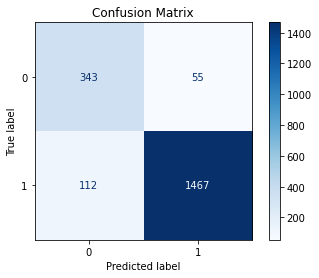

<Figure size 1080x1800 with 0 Axes>

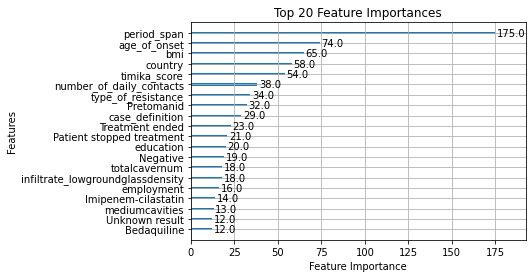

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 {'Testing Accuracy': 0.9155285786545271,
  'Sensitivity (Recall)': 0.9290690310322989,
  'Specificity': 0.8618090452261307})

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=0.3, reg_lambda=19,  random_state=42)
evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=29, reg_lambda=29,  random_state=42)
# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=219, reg_lambda=919,  random_state=42)

#### different imputation methods

In [166]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

imputation_methods = {
    'Mean Imputation': SimpleImputer(strategy='mean'),
    'Median Imputation': SimpleImputer(strategy='median'),
    'Most Frequent Imputation': SimpleImputer(strategy='most_frequent'),
    'Constant Imputation': SimpleImputer(strategy='constant', fill_value=0),
    'KNN Imputation': KNNImputer(n_neighbors=5),
    'Iterative Imputation': IterativeImputer(random_state=42)
}


Evaluating Mean Imputation...
Accuracy: 0.9287
Sensitivity (Recall): 0.9607
Specificity: 0.8015


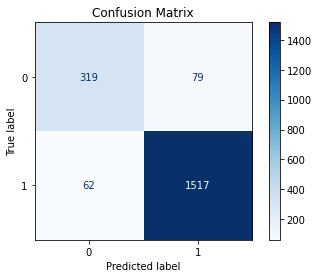

Evaluating Median Imputation...
Accuracy: 0.9347
Sensitivity (Recall): 0.9664
Specificity: 0.8090


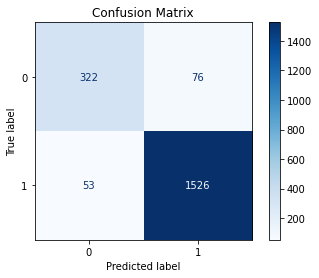

Evaluating Most Frequent Imputation...
Accuracy: 0.9312
Sensitivity (Recall): 0.9601
Specificity: 0.8166


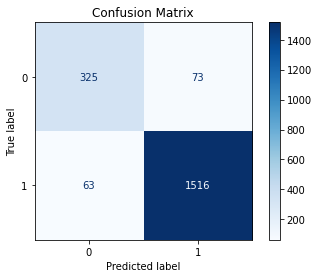

Evaluating Constant Imputation...
Accuracy: 0.9322
Sensitivity (Recall): 0.9639
Specificity: 0.8065


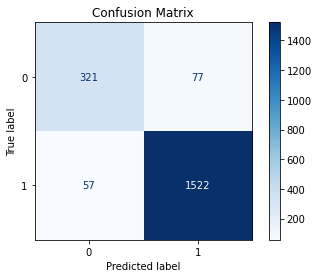

Evaluating KNN Imputation...


In [ ]:
def evaluate_imputation_method(imputer, X, y, test_size=0.2, random_state=42):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y, shuffle=True
    )
    # Apply imputation to training and testing data separately
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Resample the training data to address class imbalance
    ros = RandomOverSampler(random_state=random_state)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

    # Initialize and train the XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    model.fit(X_train_resampled, y_train_resampled)

    # Predict on the test data
    y_test_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate sensitivity (recall) and specificity
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    specificity = recall_score(y_test, y_test_pred, pos_label=0)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Compile metrics into a dictionary
    metrics = {
        'Accuracy': accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity
    }

    # Print metrics
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return metrics, model, cm
# Assuming 'clinical_lung_features' is your DataFrame of features
# and 'clinical_lung_target' is your target variable

results = {}

for method_name, imputer in imputation_methods.items():
    print(f"Evaluating {method_name}...")
    metrics, model, cm  = evaluate_imputation_method(imputer, clinical_lung_features, clinical_lung_target)
    # results[method_name] = accuracy
    # print(f"{method_name} Accuracy: {accuracy:.4f}\n")
    # print(metrics)
    # print(cm)



#### grid search on regularisation values

Best Parameters: {'reg_alpha': 1, 'reg_lambda': 0}
Best Score: 0.9342
Testing Accuracy: 0.9342
Sensitivity (Recall): 0.9645
Specificity: 0.8141


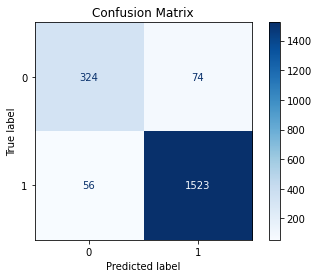

In [134]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

def grid_search_xgboost_no_cv(X_train, y_train, X_test, y_test, param_grid, scoring='accuracy', random_state=42):
    """
    Performs grid search to optimize reg_alpha and reg_lambda for XGBoost classifier without cross-validation.

    Parameters:
    - X_train (pd.DataFrame or np.array): Training feature set.
    - y_train (pd.Series or np.array): Training target variable.
    - X_test (pd.DataFrame or np.array): Testing feature set.
    - y_test (pd.Series or np.array): Testing target variable.
    - param_grid (dict): Dictionary with parameter names (`reg_alpha`, `reg_lambda`) as keys and lists of parameter settings to try as values.
    - scoring (str): Scoring metric for evaluation ('accuracy', 'sensitivity', or 'specificity').
    - random_state (int): Random seed for reproducibility.

    Returns:
    - best_params (dict): Best parameter combination found.
    - best_score (float): Best score achieved with the best parameter combination.
    - best_model (XGBClassifier): Best estimator found by the grid search.
    """
    best_score = -np.inf
    best_params = None
    best_model = None

    # Iterate over all combinations of reg_alpha and reg_lambda
    for reg_alpha in param_grid['reg_alpha']:
        for reg_lambda in param_grid['reg_lambda']:
            # Initialize the XGBoost classifier with current parameters
            model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                                  reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                  random_state=random_state)
            # Train the model
            model.fit(X_train, y_train)

            # Predict on the test data
            y_test_pred = model.predict(X_test)

            # Calculate the desired scoring metric
            if scoring == 'accuracy':
                score = accuracy_score(y_test, y_test_pred)
            elif scoring == 'sensitivity':
                score = recall_score(y_test, y_test_pred, pos_label=1)
            elif scoring == 'specificity':
                score = recall_score(y_test, y_test_pred, pos_label=0)
            else:
                raise ValueError("Unsupported scoring metric. Choose from 'accuracy', 'sensitivity', or 'specificity'.")

            # Update best parameters if current score is better
            if score > best_score:
                best_score = score
                best_params = {'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda}
                best_model = model

    return best_params, best_score, best_model


param_grid = {
    'reg_alpha': [0, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.1, 1, 10, 100]
}

# Assuming X_train_resampled and y_train_resampled are your training data
# Assuming X_train_resampled, y_train_resampled, X_test, and y_test are your datasets
best_params, best_score, best_model = grid_search_xgboost_no_cv(
    X_train_resampled, y_train_resampled, X_test, y_test, param_grid, scoring='accuracy'
)

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test data
y_test_pred = best_model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate sensitivity (recall) and specificity
sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
specificity = recall_score(y_test, y_test_pred, pos_label=0)

# Compile metrics into a dictionary
metrics = {
    'Testing Accuracy': test_accuracy,
    'Sensitivity (Recall)': sensitivity,
    'Specificity': specificity
}

# Print metrics
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
e

### removing period span columns again

Testing Accuracy: 0.8801
Sensitivity (Recall): 0.9221
Specificity: 0.7136


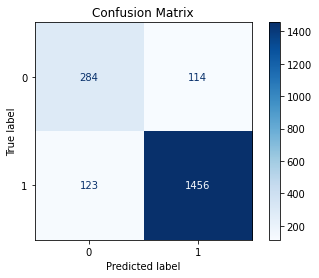

<Figure size 1080x1800 with 0 Axes>

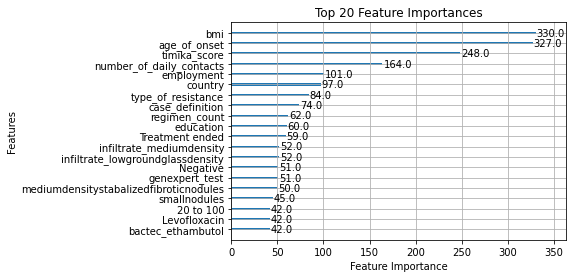

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 {'Testing Accuracy': 0.8801213960546282,
  'Sensitivity (Recall)': 0.922102596580114,
  'Specificity': 0.7135678391959799})

In [93]:
X_train_resampled.drop(columns=['period_span'], inplace=True)
X_test.drop(columns=['period_span'], inplace=True)


evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, random_state=42)

In [94]:
dropping period span drops accuracy by 5%, sensitivity by 2%, specificity by 8%

SyntaxError: invalid syntax (1037674308.py, line 1)

### Incorporate Class Weights

### adjust classification threshold

In [102]:
from sklearn.metrics import recall_score, precision_recall_curve

# Obtain predicted probabilities
y_test_probs = model.predict_proba(X_test)[:, 1]

# Determine optimal threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
# optimal_threshold = thresholds[optimal_idx]
optimal_threshold = 0.7


# Apply the optimal threshold
y_test_pred_optimal = (y_test_probs >= optimal_threshold).astype(int)

# Evaluate performance
sensitivity_optimal = recall_score(y_test, y_test_pred_optimal, pos_label=1)
specificity_optimal = recall_score(y_test, y_test_pred_optimal, pos_label=0)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Sensitivity (Recall) at Optimal Threshold: {sensitivity_optimal:.4f}")
print(f"Specificity at Optimal Threshold: {specificity_optimal:.4f}")


Optimal Threshold: 0.70
Sensitivity (Recall) at Optimal Threshold: 0.5370
Specificity at Optimal Threshold: 0.4472
